In [1]:
import pandas as pd
import numpy as np

In [2]:
train_dataset = pd.read_csv('/kaggle/input/burnout-datathon-ieeecsmuj/train.csv')
test_dataset = pd.read_csv("/kaggle/input/burnout-datathon-ieeecsmuj/test.csv")

In [3]:
print(train_dataset.head())

   Unique ID  Rider_ID category_x  Circuit_Length_km  Laps  Grid_Position  \
0    1894944      2659      Moto2              4.874    22             17   
1      23438      5205      Moto2              3.875    24              7   
2     939678      7392      Moto3              5.647    25              5   
3    1196312      7894      Moto3              4.810    19              3   
4    1033899      6163     MotoGP              5.809    25             21   

   Avg_Speed_kmh Track_Condition  Humidity_% Tire_Compound_Front  ... air  \
0         264.66             Wet          61                Hard  ...  23   
1         177.56             Wet          77                Soft  ...  12   
2         317.74             Dry          87                Soft  ...  22   
3         321.82             Wet          43                Soft  ...  23   
4         239.92             Wet          47                Hard  ...  22   

  ground  starts  finishes with_points  podiums  wins  min_year  max_year 

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914056 entries, 0 to 1914055
Data columns (total 45 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Unique ID                        int64  
 1   Rider_ID                         int64  
 2   category_x                       object 
 3   Circuit_Length_km                float64
 4   Laps                             int64  
 5   Grid_Position                    int64  
 6   Avg_Speed_kmh                    float64
 7   Track_Condition                  object 
 8   Humidity_%                       int64  
 9   Tire_Compound_Front              object 
 10  Tire_Compound_Rear               object 
 11  Penalty                          object 
 12  Championship_Points              int64  
 13  Championship_Position            int64  
 14  Session                          object 
 15  year_x                           int64  
 16  sequence                         int64  
 17  rider   

In [5]:
train_dataset.isnull().sum()

Unique ID                               0
Rider_ID                                0
category_x                              0
Circuit_Length_km                       0
Laps                                    0
Grid_Position                           0
Avg_Speed_kmh                           0
Track_Condition                         0
Humidity_%                              0
Tire_Compound_Front                     0
Tire_Compound_Rear                      0
Penalty                            321292
Championship_Points                     0
Championship_Position                   0
Session                                 0
year_x                                  0
sequence                                0
rider                                   0
team                                    0
bike                                    0
position                                0
points                                  0
shortname                               0
circuit_name                      

In [6]:
train_dataset.columns

Index(['Unique ID', 'Rider_ID', 'category_x', 'Circuit_Length_km', 'Laps',
       'Grid_Position', 'Avg_Speed_kmh', 'Track_Condition', 'Humidity_%',
       'Tire_Compound_Front', 'Tire_Compound_Rear', 'Penalty',
       'Championship_Points', 'Championship_Position', 'Session', 'year_x',
       'sequence', 'rider', 'team', 'bike', 'position', 'points', 'shortname',
       'circuit_name', 'rider_name', 'team_name', 'bike_name',
       'Lap_Time_Seconds', 'Corners_per_Lap',
       'Tire_Degradation_Factor_per_Lap', 'Pit_Stop_Duration_Seconds',
       'Ambient_Temperature_Celsius', 'Track_Temperature_Celsius', 'weather',
       'track', 'air', 'ground', 'starts', 'finishes', 'with_points',
       'podiums', 'wins', 'min_year', 'max_year', 'years_active'],
      dtype='object')

In [7]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df_encoded_train = train_dataset.copy()
df_encoded_test = test_dataset.copy()

label_encoder = LabelEncoder()

label_encode_columns = ['rider_name', 'circuit_name', 'shortname', 'team_name', 'bike_name']

for col in label_encode_columns:
    df_encoded_train[col + '_encoded'] = label_encoder.fit_transform(df_encoded_train[col].astype(str))
    df_encoded_test[col + '_encoded'] = label_encoder.transform(df_encoded_test[col].astype(str))

one_hot_columns = ['category_x', 'Track_Condition', 'Tire_Compound_Front', 
                  'Tire_Compound_Rear', 'Penalty', 'Session', 'weather', 'track']

df_encoded_train = pd.get_dummies(df_encoded_train, columns=one_hot_columns, drop_first=True)
df_encoded_test = pd.get_dummies(df_encoded_test, columns=one_hot_columns, drop_first=True)

cols_to_drop = label_encode_columns + ['shortname', 'team_name', 'bike_name']
df_encoded_train = df_encoded_train.drop(columns=cols_to_drop, errors='ignore')
df_encoded_test = df_encoded_test.drop(columns=cols_to_drop, errors='ignore')



print("Training data shape:", df_encoded_train.shape)
print("Test data shape:", df_encoded_test.shape)
print("Encoded columns count:", len(df_encoded_train.columns))



Training data shape: (1914056, 59)
Test data shape: (546874, 58)
Encoded columns count: 59


In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
X = df_encoded_train.drop(columns=['Lap_Time_Seconds', 'Unique ID', 'Rider_ID', 'year_x', 'rider', 'team', 'bike'])
y = df_encoded_train['Lap_Time_Seconds']
X_test = df_encoded_test.drop(columns=['Unique ID', 'Rider_ID', 'year_x', 'rider', 'team', 'bike'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def objective(trial):
    param = {
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'gpu_id': 0, 
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'n_jobs': -1

    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=1000, 
        evals=[(dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    y_pred = model.predict(dval)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=1) 
print('Best trial:')
trial = study.best_trial
print(f'RMSE: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')
best_params = {
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'gpu_id': 0,
    'random_state': 42,
    **study.best_params
}

dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test)
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train')],
    early_stopping_rounds=50,
    verbose_eval=100
)
test_predictions = final_model.predict(dtest)
submission = pd.DataFrame({
    'Unique ID': df_encoded_test['Unique ID'],
    'Lap_Time_Seconds': test_predictions
})
submission.to_csv('submission_final.csv', index=False)
print("saved")

[I 2025-06-14 09:39:20,673] A new study created in memory with name: no-name-f0335de7-76cb-463a-ba2f-f0fa2b2f8a19
[I 2025-06-14 09:39:42,716] Trial 0 finished with value: 11.357183801032358 and parameters: {'max_depth': 3, 'learning_rate': 0.028997060198718578, 'n_estimators': 156, 'min_child_weight': 6, 'gamma': 0.19165289474641686, 'subsample': 0.6399307367737757, 'colsample_bytree': 0.7724720976737713, 'reg_alpha': 9.019193674870403, 'reg_lambda': 6.591575801079177}. Best is trial 0 with value: 11.357183801032358.
[I 2025-06-14 09:40:09,566] Trial 1 finished with value: 10.627412148950173 and parameters: {'max_depth': 7, 'learning_rate': 0.01058045881554835, 'n_estimators': 680, 'min_child_weight': 2, 'gamma': 0.2903299916289516, 'subsample': 0.9673901309631876, 'colsample_bytree': 0.7601721103748319, 'reg_alpha': 9.892067596799853, 'reg_lambda': 1.9074801564646593}. Best is trial 1 with value: 10.627412148950173.
[I 2025-06-14 09:40:51,273] Trial 2 finished with value: 1.7645460173

Best trial:
  RMSE: 0.0900
  Params: 
    max_depth: 10
    learning_rate: 0.2963448888665282
    n_estimators: 930
    min_child_weight: 4
    gamma: 0.01545404291798122
    subsample: 0.8208154703875714
    colsample_bytree: 0.6572137696396126
    reg_alpha: 2.4501802897942953
    reg_lambda: 9.431645594361553
[0]	train-rmse:11.41537
[100]	train-rmse:4.78301
[200]	train-rmse:2.12965
[300]	train-rmse:0.94010
[400]	train-rmse:0.41151
[500]	train-rmse:0.17980
[600]	train-rmse:0.09055
[700]	train-rmse:0.05869
[800]	train-rmse:0.05406
[900]	train-rmse:0.05198
[999]	train-rmse:0.05046
Submission file saved as 'submission_final.csv'


Using device: cuda


[I 2025-06-14 10:45:21,161] A new study created in memory with name: no-name-5621589b-665f-4cc5-a0f2-8d9dcba3fd85


Epoch [10/100], Train Loss: 39176.6394, Val Loss: 31812.0641
Epoch [20/100], Train Loss: 39171.7739, Val Loss: 31806.9664
Epoch [30/100], Train Loss: 39166.8953, Val Loss: 31801.9303
Epoch [40/100], Train Loss: 39160.7424, Val Loss: 31796.9000
Epoch [50/100], Train Loss: 39151.4517, Val Loss: 31791.7910
Epoch [60/100], Train Loss: 39149.1182, Val Loss: 31786.6141
Epoch [70/100], Train Loss: 39146.7635, Val Loss: 31781.3320
Epoch [80/100], Train Loss: 39135.6900, Val Loss: 31775.9656
Epoch [90/100], Train Loss: 39123.6231, Val Loss: 31770.4535


[I 2025-06-14 10:45:27,297] Trial 0 finished with value: 31764.8255859375 and parameters: {'n_layers': 1, 'n_units_l1': 23, 'dropout_l1': 0.25275380747597154, 'batch_size': 16, 'learning_rate': 1.3512592173853275e-05, 'weight_decay': 0.0008159292579610498}. Best is trial 0 with value: 31764.8255859375.


Epoch [100/100], Train Loss: 39119.6413, Val Loss: 31764.8256
Epoch [10/100], Train Loss: 4038.3629, Val Loss: 938.9952
Epoch [20/100], Train Loss: 3174.2007, Val Loss: 442.4306
Epoch [30/100], Train Loss: 2835.1305, Val Loss: 150.8033


[I 2025-06-14 10:45:28,296] Trial 1 finished with value: 150.80333455403647 and parameters: {'n_layers': 3, 'n_units_l1': 91, 'dropout_l1': 0.2421923639950254, 'n_units_l2': 38, 'dropout_l2': 0.3354494221491638, 'n_units_l3': 23, 'dropout_l3': 0.32687330448943497, 'batch_size': 64, 'learning_rate': 0.004881173557644558, 'weight_decay': 1.6133291200486806e-05}. Best is trial 1 with value: 150.80333455403647.


Early stopping at epoch 40
Epoch [10/100], Train Loss: 3921.6491, Val Loss: 590.0200
Epoch [20/100], Train Loss: 4027.6441, Val Loss: 484.3877


[I 2025-06-14 10:45:30,453] Trial 2 finished with value: 289.49371643066405 and parameters: {'n_layers': 3, 'n_units_l1': 47, 'dropout_l1': 0.15667062164809234, 'n_units_l2': 16, 'dropout_l2': 0.1277391664571504, 'n_units_l3': 28, 'dropout_l3': 0.4528137125587439, 'batch_size': 16, 'learning_rate': 0.005419852625700108, 'weight_decay': 0.00012943276795974329}. Best is trial 1 with value: 150.80333455403647.


Early stopping at epoch 27
Epoch [10/100], Train Loss: 3228.0880, Val Loss: 466.9076
Epoch [20/100], Train Loss: 2767.0039, Val Loss: 341.2514


[I 2025-06-14 10:45:32,461] Trial 3 finished with value: 295.1533905029297 and parameters: {'n_layers': 3, 'n_units_l1': 53, 'dropout_l1': 0.3558838759891202, 'n_units_l2': 31, 'dropout_l2': 0.4273778640702066, 'n_units_l3': 56, 'dropout_l3': 0.20643264456697855, 'batch_size': 16, 'learning_rate': 0.00472049785464082, 'weight_decay': 0.003950037476807548}. Best is trial 1 with value: 150.80333455403647.


Early stopping at epoch 25
Epoch [10/100], Train Loss: 31092.2871, Val Loss: 28317.0008
Epoch [20/100], Train Loss: 13393.9057, Val Loss: 12032.3303
Epoch [30/100], Train Loss: 4465.0778, Val Loss: 3570.8177
Epoch [40/100], Train Loss: 2688.1485, Val Loss: 1292.1359
Epoch [50/100], Train Loss: 2321.3877, Val Loss: 835.4936
Epoch [60/100], Train Loss: 2436.3738, Val Loss: 751.5465
Epoch [70/100], Train Loss: 2049.9290, Val Loss: 658.6843
Epoch [80/100], Train Loss: 2408.5983, Val Loss: 626.7865
Epoch [90/100], Train Loss: 2418.8607, Val Loss: 532.7146


[I 2025-06-14 10:45:35,911] Trial 4 finished with value: 513.6531982421875 and parameters: {'n_layers': 1, 'n_units_l1': 21, 'dropout_l1': 0.3191218853519727, 'batch_size': 32, 'learning_rate': 0.003242071977744403, 'weight_decay': 3.954509352998663e-05}. Best is trial 1 with value: 150.80333455403647.


Epoch [100/100], Train Loss: 2038.1963, Val Loss: 513.6532
Epoch [10/100], Train Loss: 17565.6510, Val Loss: 19676.6650
Epoch [20/100], Train Loss: 553.4339, Val Loss: 691.7417
Epoch [30/100], Train Loss: 342.7773, Val Loss: 439.4323
Epoch [40/100], Train Loss: 292.2902, Val Loss: 353.5051
Epoch [50/100], Train Loss: 232.8741, Val Loss: 285.8421
Epoch [60/100], Train Loss: 163.7743, Val Loss: 235.7261
Epoch [70/100], Train Loss: 150.3177, Val Loss: 191.3313
Epoch [80/100], Train Loss: 149.3706, Val Loss: 159.4909
Epoch [90/100], Train Loss: 132.2486, Val Loss: 132.8125


[I 2025-06-14 10:45:37,251] Trial 5 finished with value: 109.98445892333984 and parameters: {'n_layers': 1, 'n_units_l1': 238, 'dropout_l1': 0.15644603948715652, 'batch_size': 128, 'learning_rate': 0.007712657669540492, 'weight_decay': 0.0034632632699019145}. Best is trial 5 with value: 109.98445892333984.


Epoch [100/100], Train Loss: 134.0314, Val Loss: 109.9845
Epoch [10/100], Train Loss: 37777.0859, Val Loss: 39752.0039
Epoch [20/100], Train Loss: 37775.5922, Val Loss: 39749.2227
Epoch [30/100], Train Loss: 37768.6344, Val Loss: 39745.8789
Epoch [40/100], Train Loss: 37769.6617, Val Loss: 39741.5996
Epoch [50/100], Train Loss: 37761.1133, Val Loss: 39735.6895
Epoch [60/100], Train Loss: 37753.6523, Val Loss: 39727.4434
Epoch [70/100], Train Loss: 37741.3426, Val Loss: 39715.9785
Epoch [80/100], Train Loss: 37724.5195, Val Loss: 39699.1602
Epoch [90/100], Train Loss: 37703.2371, Val Loss: 39676.1484


[I 2025-06-14 10:45:38,889] Trial 6 finished with value: 39644.44140625 and parameters: {'n_layers': 3, 'n_units_l1': 64, 'dropout_l1': 0.40474804120069996, 'n_units_l2': 73, 'dropout_l2': 0.1751119858471285, 'n_units_l3': 35, 'dropout_l3': 0.34536527575663506, 'batch_size': 128, 'learning_rate': 4.3298805358606685e-05, 'weight_decay': 0.0004517580538236366}. Best is trial 5 with value: 109.98445892333984.


Epoch [100/100], Train Loss: 37678.3879, Val Loss: 39644.4414
Epoch [10/100], Train Loss: 38170.3970, Val Loss: 35358.0234
Epoch [20/100], Train Loss: 37386.2679, Val Loss: 34648.8238
Epoch [30/100], Train Loss: 33344.1755, Val Loss: 31115.8812
Epoch [40/100], Train Loss: 25171.5058, Val Loss: 24369.8898
Epoch [50/100], Train Loss: 18268.0688, Val Loss: 17963.7971
Epoch [60/100], Train Loss: 13422.9980, Val Loss: 13377.1012
Epoch [70/100], Train Loss: 9963.5729, Val Loss: 9765.7125
Epoch [80/100], Train Loss: 8171.4394, Val Loss: 6961.8031
Epoch [90/100], Train Loss: 7052.7923, Val Loss: 5043.2514


[I 2025-06-14 10:45:42,859] Trial 7 finished with value: 3886.32099609375 and parameters: {'n_layers': 2, 'n_units_l1': 21, 'dropout_l1': 0.4696524508625324, 'n_units_l2': 141, 'dropout_l2': 0.15127656083200147, 'batch_size': 32, 'learning_rate': 0.0002347668196351814, 'weight_decay': 0.0047631247698360435}. Best is trial 5 with value: 109.98445892333984.


Epoch [100/100], Train Loss: 6118.3381, Val Loss: 3886.3210
Epoch [10/100], Train Loss: 34760.0709, Val Loss: 37947.7904
Epoch [20/100], Train Loss: 24951.5941, Val Loss: 27284.7246
Epoch [30/100], Train Loss: 13264.5807, Val Loss: 14494.0674
Epoch [40/100], Train Loss: 5880.6178, Val Loss: 5899.9880
Epoch [50/100], Train Loss: 3162.2300, Val Loss: 2336.0681
Epoch [60/100], Train Loss: 2612.6818, Val Loss: 1231.7110
Epoch [70/100], Train Loss: 2612.6582, Val Loss: 953.7291
Epoch [80/100], Train Loss: 2352.9229, Val Loss: 842.7053
Epoch [90/100], Train Loss: 2601.2016, Val Loss: 792.3134


[I 2025-06-14 10:45:44,913] Trial 8 finished with value: 751.6936442057291 and parameters: {'n_layers': 1, 'n_units_l1': 32, 'dropout_l1': 0.4579766151854724, 'batch_size': 64, 'learning_rate': 0.003240518703285433, 'weight_decay': 0.0053691848234407764}. Best is trial 5 with value: 109.98445892333984.


Epoch [100/100], Train Loss: 2705.0734, Val Loss: 751.6936
Epoch [10/100], Train Loss: 37711.2516, Val Loss: 37075.7305
Epoch [20/100], Train Loss: 37662.3699, Val Loss: 37033.6536
Epoch [30/100], Train Loss: 37617.3150, Val Loss: 36986.2188
Epoch [40/100], Train Loss: 37555.9889, Val Loss: 36931.0911
Epoch [50/100], Train Loss: 37496.3125, Val Loss: 36866.3776
Epoch [60/100], Train Loss: 37406.7547, Val Loss: 36789.7865
Epoch [70/100], Train Loss: 37312.0805, Val Loss: 36698.6354
Epoch [80/100], Train Loss: 37199.9711, Val Loss: 36591.4544
Epoch [90/100], Train Loss: 37071.6248, Val Loss: 36465.6562


[I 2025-06-14 10:45:47,070] Trial 9 finished with value: 36320.705729166664 and parameters: {'n_layers': 1, 'n_units_l1': 92, 'dropout_l1': 0.3010181555523873, 'batch_size': 64, 'learning_rate': 0.00010576183995567101, 'weight_decay': 4.045011403163091e-05}. Best is trial 5 with value: 109.98445892333984.


Epoch [100/100], Train Loss: 36926.4068, Val Loss: 36320.7057
Epoch [10/100], Train Loss: 35018.8934, Val Loss: 34863.3086
Epoch [20/100], Train Loss: 16115.2613, Val Loss: 15540.5967
Epoch [30/100], Train Loss: 1395.2083, Val Loss: 970.7443
Epoch [40/100], Train Loss: 778.1065, Val Loss: 380.6487
Epoch [50/100], Train Loss: 689.5684, Val Loss: 232.8834
Epoch [60/100], Train Loss: 677.4251, Val Loss: 182.6620
Epoch [70/100], Train Loss: 650.4756, Val Loss: 150.6761
Epoch [80/100], Train Loss: 590.9285, Val Loss: 137.5496


[I 2025-06-14 10:45:48,580] Trial 10 finished with value: 124.14212799072266 and parameters: {'n_layers': 2, 'n_units_l1': 225, 'dropout_l1': 0.11690070281599522, 'n_units_l2': 230, 'dropout_l2': 0.4721014502064559, 'batch_size': 128, 'learning_rate': 0.0007854228839539728, 'weight_decay': 0.0009801823325740046}. Best is trial 5 with value: 109.98445892333984.


Epoch [90/100], Train Loss: 523.8085, Val Loss: 130.7412
Early stopping at epoch 96
Epoch [10/100], Train Loss: 35764.4711, Val Loss: 32622.9658
Epoch [20/100], Train Loss: 17849.3471, Val Loss: 16077.7266
Epoch [30/100], Train Loss: 1671.8949, Val Loss: 1265.6555
Epoch [40/100], Train Loss: 947.8328, Val Loss: 414.1515
Epoch [50/100], Train Loss: 776.8424, Val Loss: 247.6831
Epoch [60/100], Train Loss: 697.0816, Val Loss: 209.0454
Epoch [70/100], Train Loss: 795.5032, Val Loss: 171.9860
Epoch [80/100], Train Loss: 719.9561, Val Loss: 170.9756


[I 2025-06-14 10:45:50,124] Trial 11 finished with value: 146.1183090209961 and parameters: {'n_layers': 2, 'n_units_l1': 242, 'dropout_l1': 0.10366802338973552, 'n_units_l2': 194, 'dropout_l2': 0.4896282010100944, 'batch_size': 128, 'learning_rate': 0.000790524082278766, 'weight_decay': 0.001348056827829453}. Best is trial 5 with value: 109.98445892333984.


Epoch [90/100], Train Loss: 652.7609, Val Loss: 154.2003
Epoch [100/100], Train Loss: 624.7858, Val Loss: 153.1862
Epoch [10/100], Train Loss: 30889.0504, Val Loss: 34539.9902
Epoch [20/100], Train Loss: 4708.8510, Val Loss: 5189.2324
Epoch [30/100], Train Loss: 722.6064, Val Loss: 399.7267
Epoch [40/100], Train Loss: 506.9703, Val Loss: 178.5813
Epoch [50/100], Train Loss: 512.7705, Val Loss: 132.4632
Epoch [60/100], Train Loss: 444.8415, Val Loss: 124.9824
Epoch [70/100], Train Loss: 434.6157, Val Loss: 103.1154
Epoch [80/100], Train Loss: 414.6536, Val Loss: 101.1497


[I 2025-06-14 10:45:51,551] Trial 12 finished with value: 86.52241516113281 and parameters: {'n_layers': 2, 'n_units_l1': 246, 'dropout_l1': 0.174843480384495, 'n_units_l2': 239, 'dropout_l2': 0.320786683984024, 'batch_size': 128, 'learning_rate': 0.001005453896213294, 'weight_decay': 0.0016824160487714014}. Best is trial 12 with value: 86.52241516113281.


Epoch [90/100], Train Loss: 417.2138, Val Loss: 94.7670
Early stopping at epoch 94
Epoch [10/100], Train Loss: 35742.7719, Val Loss: 40456.5723
Epoch [20/100], Train Loss: 28481.4238, Val Loss: 32531.5186
Epoch [30/100], Train Loss: 12056.6932, Val Loss: 14773.1431
Epoch [40/100], Train Loss: 1963.9174, Val Loss: 2709.2253
Epoch [50/100], Train Loss: 839.6932, Val Loss: 985.8944
Epoch [60/100], Train Loss: 754.5538, Val Loss: 572.1147
Epoch [70/100], Train Loss: 789.7924, Val Loss: 394.2469
Epoch [80/100], Train Loss: 729.3792, Val Loss: 344.6267


[I 2025-06-14 10:45:53,117] Trial 13 finished with value: 293.8261489868164 and parameters: {'n_layers': 2, 'n_units_l1': 151, 'dropout_l1': 0.19412291209392663, 'n_units_l2': 97, 'dropout_l2': 0.2739011447922887, 'batch_size': 128, 'learning_rate': 0.0008030490469729095, 'weight_decay': 0.001945777046863464}. Best is trial 12 with value: 86.52241516113281.


Epoch [90/100], Train Loss: 644.0363, Val Loss: 297.0491
Epoch [100/100], Train Loss: 670.9473, Val Loss: 297.8290
Epoch [10/100], Train Loss: 19143.8109, Val Loss: 15972.4736
Epoch [20/100], Train Loss: 704.8749, Val Loss: 748.3757
Epoch [30/100], Train Loss: 505.8425, Val Loss: 351.1943
Epoch [40/100], Train Loss: 417.0206, Val Loss: 278.6147
Epoch [50/100], Train Loss: 341.2918, Val Loss: 212.5195
Epoch [60/100], Train Loss: 302.9237, Val Loss: 171.3020
Epoch [70/100], Train Loss: 243.7872, Val Loss: 134.0826
Epoch [80/100], Train Loss: 260.0149, Val Loss: 101.5471


[I 2025-06-14 10:45:54,500] Trial 14 finished with value: 59.15256118774414 and parameters: {'n_layers': 1, 'n_units_l1': 152, 'dropout_l1': 0.22417262762394424, 'batch_size': 128, 'learning_rate': 0.009764484417391481, 'weight_decay': 0.008349399359387616}. Best is trial 14 with value: 59.15256118774414.


Epoch [90/100], Train Loss: 193.1143, Val Loss: 68.3324
Epoch [100/100], Train Loss: 218.4518, Val Loss: 62.8804
Epoch [10/100], Train Loss: 31583.0223, Val Loss: 36228.2891
Epoch [20/100], Train Loss: 5288.2516, Val Loss: 5435.9136
Epoch [30/100], Train Loss: 928.4748, Val Loss: 534.6576
Epoch [40/100], Train Loss: 761.4190, Val Loss: 264.2476
Epoch [50/100], Train Loss: 757.8509, Val Loss: 215.1558
Epoch [60/100], Train Loss: 692.1031, Val Loss: 176.5483
Epoch [70/100], Train Loss: 811.7339, Val Loss: 158.8813
Epoch [80/100], Train Loss: 717.3492, Val Loss: 153.9147


[I 2025-06-14 10:45:55,955] Trial 15 finished with value: 136.31534576416016 and parameters: {'n_layers': 2, 'n_units_l1': 147, 'dropout_l1': 0.22866431472590312, 'n_units_l2': 124, 'dropout_l2': 0.2985021347466739, 'batch_size': 128, 'learning_rate': 0.0014826273118949166, 'weight_decay': 0.009851485016312854}. Best is trial 14 with value: 59.15256118774414.


Epoch [90/100], Train Loss: 722.1454, Val Loss: 151.5695
Early stopping at epoch 97
Epoch [10/100], Train Loss: 38023.1789, Val Loss: 39848.9102
Epoch [20/100], Train Loss: 37912.7281, Val Loss: 39729.9180
Epoch [30/100], Train Loss: 37753.0687, Val Loss: 39563.2031
Epoch [40/100], Train Loss: 37526.4414, Val Loss: 39329.6523
Epoch [50/100], Train Loss: 37220.9078, Val Loss: 39013.7686
Epoch [60/100], Train Loss: 36837.8141, Val Loss: 38603.4131
Epoch [70/100], Train Loss: 36342.8746, Val Loss: 38094.4277
Epoch [80/100], Train Loss: 35766.5133, Val Loss: 37487.4941


[I 2025-06-14 10:45:57,301] Trial 16 finished with value: 35988.373046875 and parameters: {'n_layers': 1, 'n_units_l1': 148, 'dropout_l1': 0.1739701697205946, 'batch_size': 128, 'learning_rate': 0.0002892000244460168, 'weight_decay': 0.00024035659369601358}. Best is trial 14 with value: 59.15256118774414.


Epoch [90/100], Train Loss: 35091.6871, Val Loss: 36782.7344
Epoch [100/100], Train Loss: 34311.9383, Val Loss: 35988.3730
Epoch [10/100], Train Loss: 36560.7395, Val Loss: 33653.8145
Epoch [20/100], Train Loss: 26372.5859, Val Loss: 23760.8643
Epoch [30/100], Train Loss: 7443.1806, Val Loss: 5750.5439
Epoch [40/100], Train Loss: 2336.4978, Val Loss: 766.6086
Epoch [50/100], Train Loss: 1680.6360, Val Loss: 428.3959
Epoch [60/100], Train Loss: 1925.0628, Val Loss: 350.7008
Epoch [70/100], Train Loss: 1778.3979, Val Loss: 299.3092
Epoch [80/100], Train Loss: 1523.4656, Val Loss: 246.2076


[I 2025-06-14 10:45:58,816] Trial 17 finished with value: 221.83079528808594 and parameters: {'n_layers': 2, 'n_units_l1': 118, 'dropout_l1': 0.27549336052642054, 'n_units_l2': 48, 'dropout_l2': 0.37749993430702833, 'batch_size': 128, 'learning_rate': 0.00131597511656367, 'weight_decay': 0.0022780306204872995}. Best is trial 14 with value: 59.15256118774414.


Epoch [90/100], Train Loss: 1523.5051, Val Loss: 233.6917
Epoch [100/100], Train Loss: 1447.7915, Val Loss: 221.8308
Epoch [10/100], Train Loss: 455.4686, Val Loss: 383.1615
Epoch [20/100], Train Loss: 251.3814, Val Loss: 146.3751
Epoch [30/100], Train Loss: 176.8970, Val Loss: 51.6250
Epoch [40/100], Train Loss: 148.1093, Val Loss: 32.2715
Epoch [50/100], Train Loss: 163.1891, Val Loss: 23.2062
Epoch [60/100], Train Loss: 143.9093, Val Loss: 19.6929
Epoch [70/100], Train Loss: 167.2244, Val Loss: 19.4042
Epoch [80/100], Train Loss: 138.5547, Val Loss: 21.1861


[I 2025-06-14 10:46:01,946] Trial 18 finished with value: 8.77572078704834 and parameters: {'n_layers': 1, 'n_units_l1': 178, 'dropout_l1': 0.21312814224911433, 'batch_size': 32, 'learning_rate': 0.009834825415160692, 'weight_decay': 0.0006593711606235692}. Best is trial 18 with value: 8.77572078704834.


Epoch [90/100], Train Loss: 161.9166, Val Loss: 15.6250
Early stopping at epoch 94
Epoch [10/100], Train Loss: 1015.8064, Val Loss: 583.2579
Epoch [20/100], Train Loss: 885.2681, Val Loss: 335.7030
Epoch [30/100], Train Loss: 696.3746, Val Loss: 160.5835
Epoch [40/100], Train Loss: 649.3225, Val Loss: 64.9924
Epoch [50/100], Train Loss: 560.2458, Val Loss: 31.7951
Epoch [60/100], Train Loss: 574.9976, Val Loss: 40.3897
Epoch [70/100], Train Loss: 532.5693, Val Loss: 29.8061
Early stopping at epoch 76


[I 2025-06-14 10:46:04,533] Trial 19 finished with value: 19.455764770507812 and parameters: {'n_layers': 1, 'n_units_l1': 81, 'dropout_l1': 0.34394612455377266, 'batch_size': 32, 'learning_rate': 0.009590376112926015, 'weight_decay': 0.00014480735680045333}. Best is trial 18 with value: 8.77572078704834.



Best trial:
  Value: 8.7757
  Params: 
    n_layers: 1
    n_units_l1: 178
    dropout_l1: 0.21312814224911433
    batch_size: 32
    learning_rate: 0.009834825415160692
    weight_decay: 0.0006593711606235692

Training final model...
Epoch [10/200], Train Loss: 388.9527, Val Loss: 256.5384
Epoch [20/200], Train Loss: 202.0493, Val Loss: 60.7365
Epoch [30/200], Train Loss: 170.3327, Val Loss: 18.7003
Epoch [40/200], Train Loss: 157.7611, Val Loss: 17.0709
Epoch [50/200], Train Loss: 152.5294, Val Loss: 20.6394
Epoch [60/200], Train Loss: 148.3977, Val Loss: 26.6106
Early stopping at epoch 61


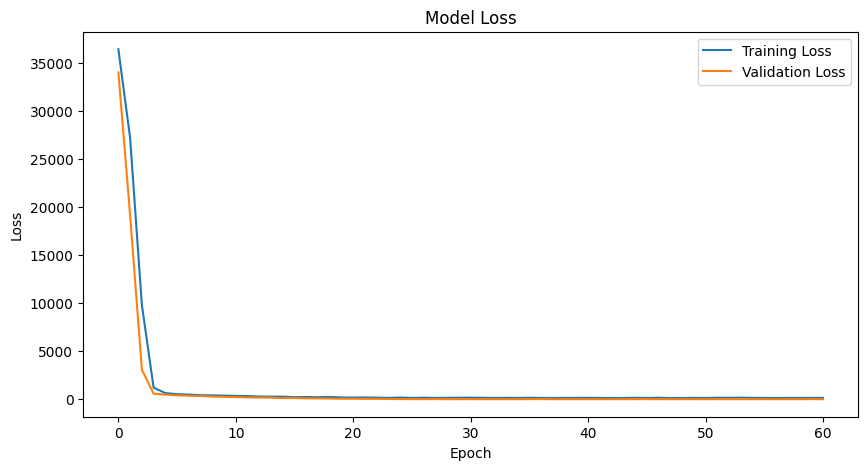

Test Loss: 13.8983


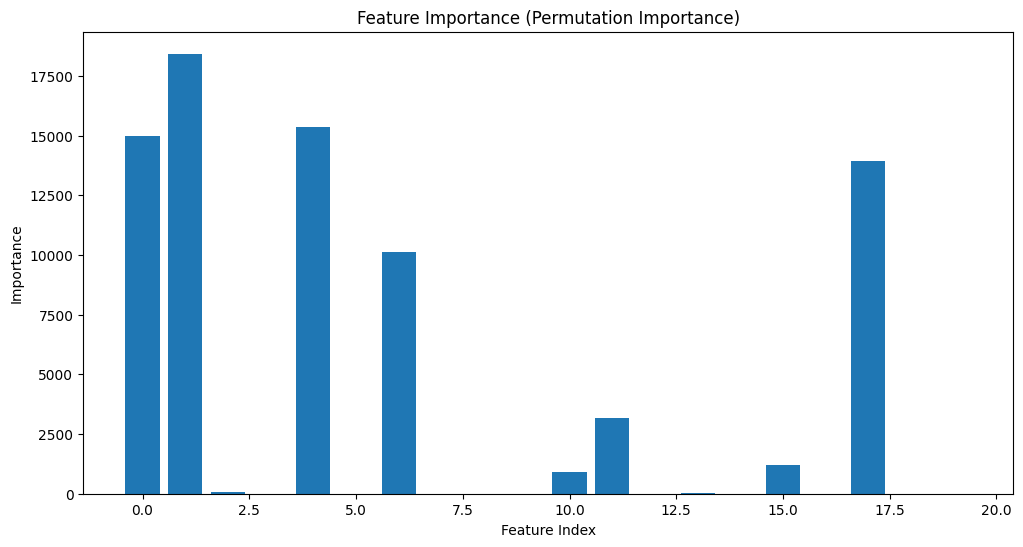

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt
from tqdm import tqdm

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create synthetic data (replace with your dataset)
def create_synthetic_data(n_samples=1000, n_features=20):
    from sklearn.datasets import make_regression
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=10,
        noise=0.1,
        random_state=42
    )
    return X, y.reshape(-1, 1)  # Reshape y to (n_samples, 1)

# Create or load your data
X, y = create_synthetic_data()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the neural network
class RegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate):
        super(RegressionNN, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_dims)):
            layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate[i]))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=100, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
        
        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

def objective(trial):
    # Hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_dims = []
    dropout_rates = []
    
    # First hidden layer
    hidden_dim = trial.suggest_int('n_units_l1', 16, 256, log=True)
    hidden_dims.append(hidden_dim)
    dropout_rate = trial.suggest_float('dropout_l1', 0.1, 0.5)
    dropout_rates.append(dropout_rate)
    
    # Additional hidden layers
    for i in range(1, n_layers):
        hidden_dim = trial.suggest_int(f'n_units_l{i+1}', 16, 256, log=True)
        hidden_dims.append(hidden_dim)
        dropout_rate = trial.suggest_float(f'dropout_l{i+1}', 0.1, 0.5)
        dropout_rates.append(dropout_rate)
    
    # Training parameters
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    
    # Create data loaders
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    
    train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False
    )
    
    # Initialize model
    model = RegressionNN(
        input_dim=X_train.shape[1],
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rates
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )
    
    # Train the model
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, 
        device, n_epochs=100, patience=10
    )
    
    # Return the best validation loss
    return min(val_losses)

# Create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print best trial
print('\nBest trial:')
trial = study.best_trial
print(f'  Value: {trial.value:.4f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Train final model with best hyperparameters
n_layers = sum(1 for k in trial.params if k.startswith('n_units_l'))
hidden_dims = [trial.params[f'n_units_l{i+1}'] for i in range(n_layers)]
dropout_rates = [trial.params[f'dropout_l{i+1}'] for i in range(n_layers)]

# Create final model
final_model = RegressionNN(
    input_dim=X_train.shape[1],
    hidden_dims=hidden_dims,
    dropout_rate=dropout_rates
).to(device)

# Create data loaders
batch_size = trial.params['batch_size']
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    final_model.parameters(), 
    lr=trial.params['learning_rate'],
    weight_decay=trial.params['weight_decay']
)

# Train the final model
print("\nTraining final model...")
final_model, train_losses, val_losses = train_model(
    final_model, train_loader, DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    ), 
    criterion, optimizer, device, n_epochs=200, patience=20
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
final_model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = final_model(X_batch)
        test_loss += criterion(outputs, y_batch).item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Feature importance (using permutation importance)
def calculate_feature_importance(model, X, y, n_repeats=10):
    model.eval()
    baseline_loss = 0.0
    with torch.no_grad():
        for i in range(len(X)):
            inputs = X[i:i+1]
            targets = y[i:i+1]
            outputs = model(inputs)
            baseline_loss += criterion(outputs, targets).item()
    baseline_loss /= len(X)
    
    feature_importance = np.zeros(X.shape[1])
    for feature_idx in range(X.shape[1]):
        total_loss = 0.0
        for _ in range(n_repeats):
            X_perturbed = X.clone()
            # Shuffle the feature
            X_perturbed[:, feature_idx] = X_perturbed[torch.randperm(X_perturbed.size(0)), feature_idx]
            
            with torch.no_grad():
                for i in range(len(X_perturbed)):
                    inputs = X_perturbed[i:i+1]
                    targets = y[i:i+1]
                    outputs = model(inputs)
                    total_loss += criterion(outputs, targets).item()
        
        total_loss /= (len(X) * n_repeats)
        feature_importance[feature_idx] = total_loss - baseline_loss
    
    return feature_importance

# Calculate feature importance
feature_importance = calculate_feature_importance(
    final_model, X_test_tensor, y_test_tensor
)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()